In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.stats.gp.upcross import gp_upcross_at_level
from sigcorr.tools.stats.gp.euler_number import GPEulerNumberPropagator
from sigcorr.tools.stats.ts.upcross import propagate_upcross

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import UpcrossCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import TestStatisticCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [2]:
input_file = "../../output/hyy-1m.h5"
#input_file = "../../output/gross_vitells-1m.h5"
asimov_input_file = input_file.split("-")[0]+"-asimov.h5"

In [3]:
#true_model = GrossVitells(None)
true_model = Hyy(None)
#true_model = Hyy2D(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [4]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        true_res_part[field] = f[field][:1000, ...]
    #true_res_part["sig_std"] = f.attrs["sig_std"]

In [5]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        asimov_res[field] = f[field][...]

In [6]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 635924.85it/s]


In [7]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 2836288.88it/s]


In [8]:
LOCAL_SIG_GRID = np.arange(0, 7.05, 0.1)

In [9]:
c0 = LOCAL_SIG_GRID[7]

In [10]:
direct_asimov_upcross_scan = []
for local_sig in LOCAL_SIG_GRID:
    upcross = gp_upcross_at_level(true_res_part["scan_xs"][:, 0], asimov_corr, local_sig)*2
    direct_asimov_upcross_scan.append(upcross)
direct_asimov_upcross_scan = np.array(direct_asimov_upcross_scan)

In [11]:
direct_true_upcross_scan = []
for local_sig in LOCAL_SIG_GRID:
    upcross = gp_upcross_at_level(true_res_part["scan_xs"][:, 0], true_cov, local_sig)*2
    direct_true_upcross_scan.append(upcross)
direct_true_upcross_scan = np.array(direct_true_upcross_scan)

In [12]:
true_upcross_scan = []
for local_sig in LOCAL_SIG_GRID:
    true_upcross_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 20000, ChainCalc([TestStatisticCalc(), UpcrossCalc(local_sig**2)]), BatchStats1Reduce()))
    true_upcross, true_upcross_err = true_upcross_covcalc.get_mean(), true_upcross_covcalc.get_stat_err()
    true_upcross_scan.append(true_upcross)
true_upcross_scan = np.array(true_upcross_scan)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 6148509.31it/s]


Text(0.5, 0, 'significance')

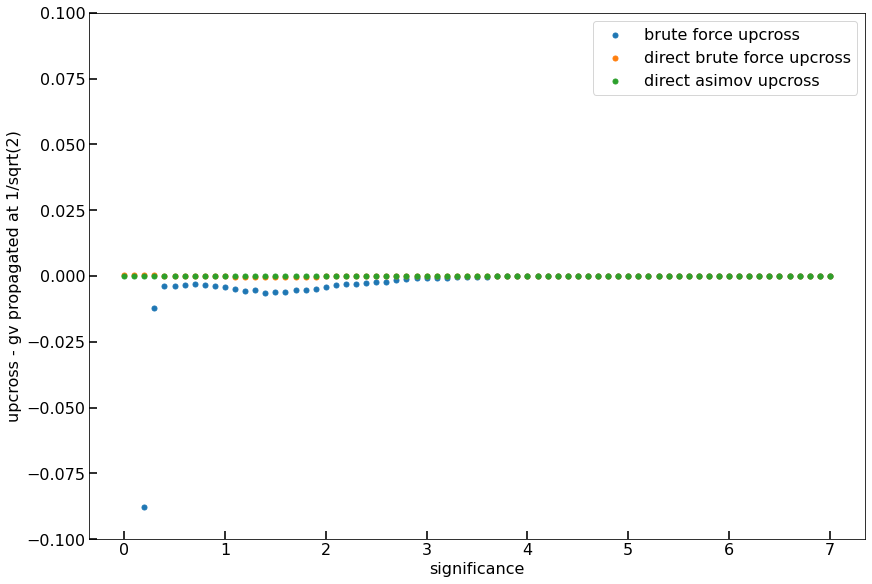

In [13]:
plt.scatter(LOCAL_SIG_GRID, true_upcross_scan.ravel() - propagate_upcross(c0**2, direct_true_upcross_scan[7], 1, LOCAL_SIG_GRID**2), label="brute force upcross")
plt.scatter(LOCAL_SIG_GRID, direct_true_upcross_scan - propagate_upcross(c0**2, direct_true_upcross_scan[7], 1, LOCAL_SIG_GRID**2), label="direct brute force upcross")
#plt.plot(LOCAL_SIG_GRID, , label="gv propagated")
plt.scatter(LOCAL_SIG_GRID, direct_asimov_upcross_scan - propagate_upcross(c0**2, direct_true_upcross_scan[7], 1, LOCAL_SIG_GRID**2), label="direct asimov upcross")
#plt.yscale("log")
plt.legend()
plt.ylim([-0.1, 0.1])
plt.ylabel("upcross - gv propagated at 1/sqrt(2)")
plt.xlabel("significance")